# Docs Impact Research
https://github.com/github/data/issues/8205


In [ ]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pwd
import os
from octopy import Hive, Presto
from utils import execute_query
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

In [68]:
create_query = """
    SELECT
        count( distinct context.dotcom_user) as dotcom_user
    FROM delta.hydro.docs_v0_page_event
    WHERE DAY >= '2025-02-01' and DAY <
        '2025-03-01'
        and context.dotcom_user is not null
        AND (
            LOWER(context.path_article) LIKE '%copilot%'
            OR LOWER(context.path_article) LIKE '%github-copilot%'
            OR LOWER(context.path_article) LIKE '%customizing-copilot%'
            OR LOWER(context.path_article) LIKE '%github-copilot-features%'
            OR LOWER(context.path_article) LIKE '%using-github-copilot%'
            OR LOWER(context.path_article) LIKE '%troubleshooting-github-copilot%'
            OR LOWER(context.path_article) LIKE '%responsible-use-of-github-copilot-features%'
            OR LOWER(context.path_article) LIKE '%building-copilot-extensions%'
            OR LOWER(context.path_article) LIKE '%copilot-chat-cookbook%'
        )
"""

print(execute_query(create_query))

   dotcom_user
0       530771


How many unique users (with login information in cookies) looked at docs in the month of February?

In [69]:
create_query = """
    SELECT
        count( distinct context.dotcom_user) as dotcom_user
    FROM delta.hydro.docs_v0_page_event
    WHERE DAY >= '2025-02-01' and DAY <
        '2025-03-01'
        and context.dotcom_user is not null
"""

print(execute_query(create_query))


   dotcom_user
0      3182501


How many Docs monthly active users are there?

In [72]:
create_query = """
WITH day_counts AS (
    SELECT
        context.dotcom_user AS dotcom_user,
        COUNT(DISTINCT day) AS day_count
    FROM delta.hydro.docs_v0_page_event
    WHERE DAY >= '2025-02-01' and DAY <
        '2025-03-01'
        AND context.dotcom_user IS NOT NULL
    GROUP BY context.dotcom_user
),
total_users AS (
    SELECT COUNT(DISTINCT context.dotcom_user) AS total
    FROM delta.hydro.docs_v0_page_event
    WHERE DAY >= '2025-02-01' and DAY <
        '2025-03-01'
        AND context.dotcom_user IS NOT NULL
)
SELECT
    SUM(CASE WHEN day_count >= 1 THEN 1 ELSE 0 END) AS users_1d_out_of_28,
    SUM(CASE WHEN day_count >= 2 THEN 1 ELSE 0 END) AS users_2d_out_of_28,
    SUM(CASE WHEN day_count >= 5 THEN 1 ELSE 0 END) AS users_5d_out_of_28,
    ROUND((SUM(CASE WHEN day_count >= 1 THEN 1 ELSE 0 END) * 100.0) / (SELECT total FROM total_users), 2) AS percentage_1d_out_of_28,
    ROUND((SUM(CASE WHEN day_count >= 2 THEN 1 ELSE 0 END) * 100.0) / (SELECT total FROM total_users), 2) AS percentage_2d_out_of_28,
    ROUND((SUM(CASE WHEN day_count >= 5 THEN 1 ELSE 0 END) * 100.0) / (SELECT total FROM total_users), 2) AS percentage_5d_out_of_28
FROM day_counts, total_users
"""

mau = execute_query(create_query)
mau

,users_1d_out_of_28,users_2d_out_of_28,users_5d_out_of_28,percentage_1d_out_of_28,percentage_2d_out_of_28,percentage_5d_out_of_28
0,3182501,915713,96339,100.0,28.8,3.0


/var/folders/47/p5glln651rs3c5hbg4r9x7s00000gn/T/ipykernel_42406/2666619412.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=categories, y=values, palette="Blues_d")


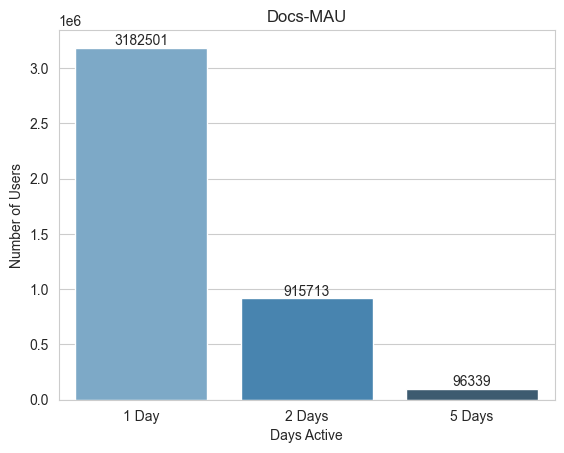

In [73]:
categories = ['1 Day', '2 Days', '5 Days']
values = mau.iloc[0, :3]

sns.set_style("whitegrid")
sns.barplot(x=categories, y=values, palette="Blues_d")
plt.title('Docs-MAU')
plt.xlabel('Days Active')
plt.ylabel('Number of Users')


for i, value in enumerate(values):
    plt.text(i, value + 0.1, str(value), ha='center', va='bottom')

plt.show()

How many Copilot-Docs monthly active user out of all Docs usage?

In [75]:
create_query = """
WITH day_counts AS (
    SELECT
        context.dotcom_user AS dotcom_user,
        COUNT(DISTINCT day) AS day_count
    FROM delta.hydro.docs_v0_page_event
    WHERE DAY >= '2025-02-01' and DAY <
        '2025-03-01'
        AND context.dotcom_user IS NOT NULL
        AND (
            LOWER(context.path_article) LIKE '%copilot%'
            OR LOWER(context.path_article) LIKE '%github-copilot%'
            OR LOWER(context.path_article) LIKE '%customizing-copilot%'
            OR LOWER(context.path_article) LIKE '%github-copilot-features%'
            OR LOWER(context.path_article) LIKE '%using-github-copilot%'
            OR LOWER(context.path_article) LIKE '%troubleshooting-github-copilot%'
            OR LOWER(context.path_article) LIKE '%responsible-use-of-github-copilot-features%'
            OR LOWER(context.path_article) LIKE '%building-copilot-extensions%'
            OR LOWER(context.path_article) LIKE '%copilot-chat-cookbook%'
        )
    GROUP BY context.dotcom_user
),
total_users AS (
    SELECT COUNT(DISTINCT context.dotcom_user) AS total
    FROM delta.hydro.docs_v0_page_event
    WHERE DAY >= '2025-02-01' and DAY <
        '2025-03-01'
        AND context.dotcom_user IS NOT NULL
)
SELECT
    SUM(CASE WHEN day_count >= 1 THEN 1 ELSE 0 END) AS users_1d_out_of_28,
    SUM(CASE WHEN day_count >= 2 THEN 1 ELSE 0 END) AS users_2d_out_of_28,
    SUM(CASE WHEN day_count >= 5 THEN 1 ELSE 0 END) AS users_5d_out_of_28,
    ROUND((SUM(CASE WHEN day_count >= 1 THEN 1 ELSE 0 END) * 100.0) / (SELECT total FROM total_users), 2) AS percentage_1d_out_of_28,
    ROUND((SUM(CASE WHEN day_count >= 2 THEN 1 ELSE 0 END) * 100.0) / (SELECT total FROM total_users), 2) AS percentage_2d_out_of_28,
    ROUND((SUM(CASE WHEN day_count >= 5 THEN 1 ELSE 0 END) * 100.0) / (SELECT total FROM total_users), 2) AS percentage_5d_out_of_28
FROM day_counts, total_users
"""

mau_copilot = execute_query(create_query)
mau_copilot

,users_1d_out_of_28,users_2d_out_of_28,users_5d_out_of_28,percentage_1d_out_of_28,percentage_2d_out_of_28,percentage_5d_out_of_28
0,530771,113095,7985,16.7,3.6,0.3


/var/folders/47/p5glln651rs3c5hbg4r9x7s00000gn/T/ipykernel_42406/3317075738.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=categories, y=values, palette="Blues_d")


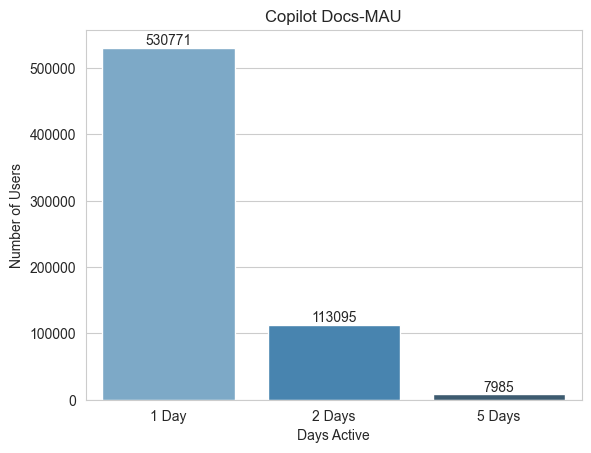

In [76]:
categories = ['1 Day', '2 Days', '5 Days']
values = mau_copilot.iloc[0, :3]

sns.set_style("whitegrid")
sns.barplot(x=categories, y=values, palette="Blues_d")
plt.title('Copilot Docs-MAU')
plt.xlabel('Days Active')
plt.ylabel('Number of Users')


for i, value in enumerate(values):
    plt.text(i, value + 0.1, str(value), ha='center', va='bottom')

plt.show()

Copilot Docs views Histogram

In [ ]:
create_query = """
    SELECT
        context.dotcom_user AS dotcom_user,
        COUNT(DISTINCT day) AS day_count
    FROM delta.hydro.docs_v0_page_event
    WHERE DAY >= '2025-02-01' and DAY <
        '2025-03-01'
        AND context.dotcom_user IS NOT NULL
        AND (
            LOWER(context.path_article) LIKE '%copilot%'
            OR LOWER(context.path_article) LIKE '%github-copilot%'
            OR LOWER(context.path_article) LIKE '%customizing-copilot%'
            OR LOWER(context.path_article) LIKE '%github-copilot-features%'
            OR LOWER(context.path_article) LIKE '%using-github-copilot%'
            OR LOWER(context.path_article) LIKE '%troubleshooting-github-copilot%'
            OR LOWER(context.path_article) LIKE '%responsible-use-of-github-copilot-features%'
            OR LOWER(context.path_article) LIKE '%building-copilot-extensions%'
            OR LOWER(context.path_article) LIKE '%copilot-chat-cookbook%'
        )
    GROUP BY context.dotcom_user
"""

hist_copilot = execute_query(create_query)
hist_copilot

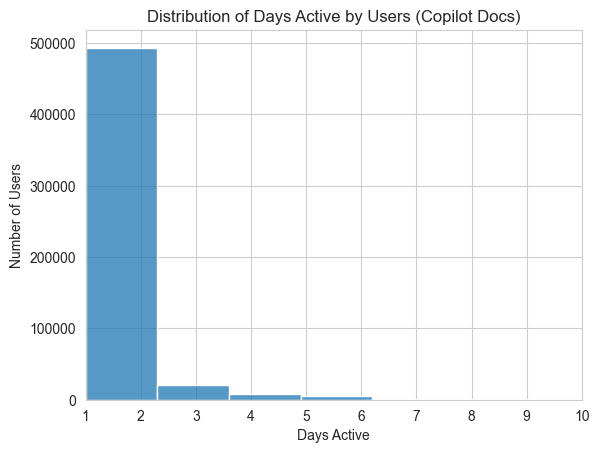

In [91]:
sns.set_style("whitegrid")
sns.histplot(data=hist_copilot, x='day_count', bins=20, kde=False)

plt.title('Distribution of Days Active by Users (Copilot Docs)')
plt.xlabel('Days Active')
plt.ylabel('Number of Users')
plt.xlim(1, 10)
plt.show()

How many unique Copilot users do we have in February? (data source: P360)

In [82]:
create_query = """
    SELECT  
            COUNT(DISTINCT user_id)
    FROM canonical.user_daily_activity_per_product
    WHERE DAY >= '2025-02-01' and DAY < '2025-03-01'
        AND lower(product) like '%copilot%'
"""

print(execute_query(create_query))

     _col0
0  5989502


In [87]:
create_query = """
    SELECT  user_id,
        COUNT(DISTINCT day) AS day_count
    FROM canonical.user_daily_activity_per_product
    WHERE DAY >= '2025-02-01' and DAY < '2025-03-01'
        AND lower(product) like '%copilot%'
    GROUP BY user_id
"""
hist_copilot_usage = execute_query(create_query)
hist_copilot_usage.head(5)

,user_id,day_count
0,57115457,26
1,89111205,21
2,91234362,26
3,105919668,22
4,152363573,13


Copilot usage Histogram

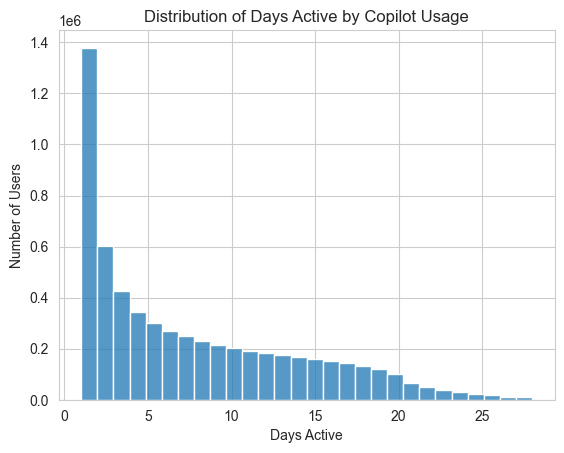

In [103]:
sns.set_style("whitegrid")
sns.histplot(data=hist_copilot_usage, x='day_count', bins=28, kde=False)
plt.title('Distribution of Days Active by Copilot Usage')
plt.xlabel('Days Active')
plt.ylabel('Number of Users')
plt.show()


In [118]:
create_query = """
WITH docs_page_views AS (
-- track all user sessions of a specific day that start on a copilot docs page
    SELECT id,
           context.dotcom_user as dotcom_user, 
           day, 
           context.href as href,
           context.referrer as referrer,
           context.path as path,
           context.path_article as path_article
    FROM delta.hydro.docs_v0_page_event
    WHERE DAY >= '2025-02-01' and DAY <
        '2025-03-01'
        and context.dotcom_user is not null
        AND (
            LOWER(context.path_article) LIKE '%copilot%'
            OR LOWER(context.path_article) LIKE '%github-copilot%'
            OR LOWER(context.path_article) LIKE '%customizing-copilot%'
            OR LOWER(context.path_article) LIKE '%github-copilot-features%'
            OR LOWER(context.path_article) LIKE '%using-github-copilot%'
            OR LOWER(context.path_article) LIKE '%troubleshooting-github-copilot%'
            OR LOWER(context.path_article) LIKE '%responsible-use-of-github-copilot-features%'
            OR LOWER(context.path_article) LIKE '%building-copilot-extensions%'
            OR LOWER(context.path_article) LIKE '%copilot-chat-cookbook%'
        )

),
get_user_id AS (

    SELECT distinct dotcom_id as user_id, 
        login
    From canonical.accounts_all 
    WHERE day = '2025-03-01'
        and account_type = 'User'
        and is_spammy = FALSE 
        and is_suspended = FALSE
        and is_staff = FALSE
        and is_disabled = FALSE

),
docs_views_with_user_id as (
-- join the user id
    SELECT 
           user_id,
           day, 
           href,
           referrer,
           path,
           path_article
    From docs_page_views d 
    JOIN get_user_id u on u.login=d.dotcom_user
),
docs_mau as (
    SELECT
        user_id,
        COUNT(DISTINCT day) AS day_count_copilot_docs
    FROM docs_views_with_user_id
    WHERE DAY >= '2025-02-01' and DAY <
        '2025-03-01'
    GROUP BY user_id
),
product_usage_mau as (

    SELECT  user_id,
        COUNT(DISTINCT day) AS day_count_copilot_usage
    FROM canonical.user_daily_activity_per_product
    WHERE DAY >= '2025-02-01' and DAY < '2025-03-01'
        AND lower(product) like '%copilot%'
    GROUP BY user_id
)
SELECT d.user_id,
    day_count_copilot_docs,
    CASE WHEN day_count_copilot_usage IS NULL THEN 0 else day_count_copilot_usage END as day_count_copilot_usage
FROM docs_mau d
LEFT JOIN product_usage_mau p on p.user_id=d.user_id
"""
usage_and_docs_copilot = execute_query(create_query)

How many Docs users go to or use the product?

In [129]:
zero_count = (usage_and_docs_copilot['day_count_copilot_usage'] == 0).sum()
total_count = len(usage_and_docs_copilot)
percentage_zeros = (zero_count / total_count) * 100
print(f"Percentage of Copilot Docs viewers with no Copilot usage: {percentage_zeros:.2f}%")

Percentage of Copilot Docs viewers with no Copilot usage: 20.78%


Cumulative distribution function

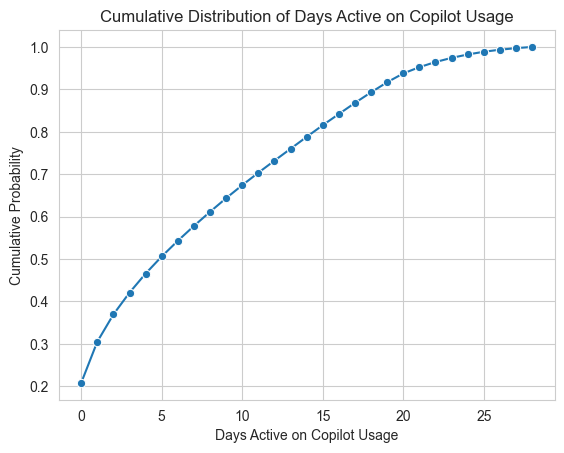

In [ ]:
sns.set_style("whitegrid")

# sort the data and calculate the cumulative distribution
sorted_data = usage_and_docs_copilot['day_count_copilot_usage'].value_counts().sort_index()
cumulative = sorted_data.cumsum() / sorted_data.sum()

sns.lineplot(x=cumulative.index, y=cumulative, marker='o')

plt.title('Cumulative Distribution of Days Active on Copilot Usage')
plt.xlabel('Days Active on Copilot Usage')
plt.ylabel('Cumulative Probability')
plt.grid(True)
plt.show()

We see again that 20% of Copilot Docs viewers don't have any Copilot usage. 50% of Copilot Docs viewer have 5 Copilot usage days or less. 

Is there a linear relationship between Copilot Docs views and Copilot usage?

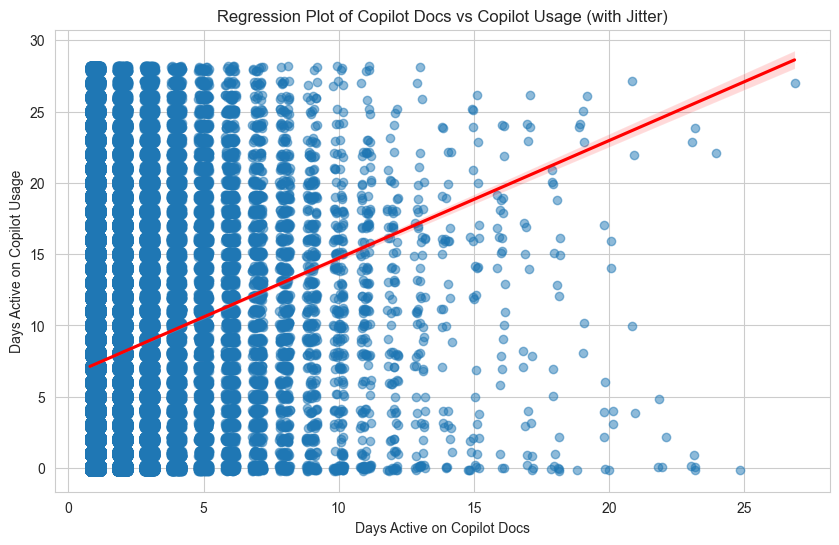

In [119]:
plt.figure(figsize=(10, 6))

# Add jitter for better visualization
jitter_docs = usage_and_docs_copilot['day_count_copilot_docs'] + np.random.uniform(-0.2, 0.2, size=len(usage_and_docs_copilot))
jitter_usage = usage_and_docs_copilot['day_count_copilot_usage'] + np.random.uniform(-0.2, 0.2, size=len(usage_and_docs_copilot))

sns.regplot(x=jitter_docs, y=jitter_usage, scatter_kws={'alpha': 0.5}, line_kws={'color': 'red'})
plt.title('Regression Plot of Copilot Docs vs Copilot Usage (with Jitter)')
plt.xlabel('Days Active on Copilot Docs')
plt.ylabel('Days Active on Copilot Usage')
plt.grid(True)
plt.show()

It seems like the regression line is very much dependent on the few extrem values in Docs views so we are going to exclude them. 

<Figure size 1000x600 with 0 Axes>

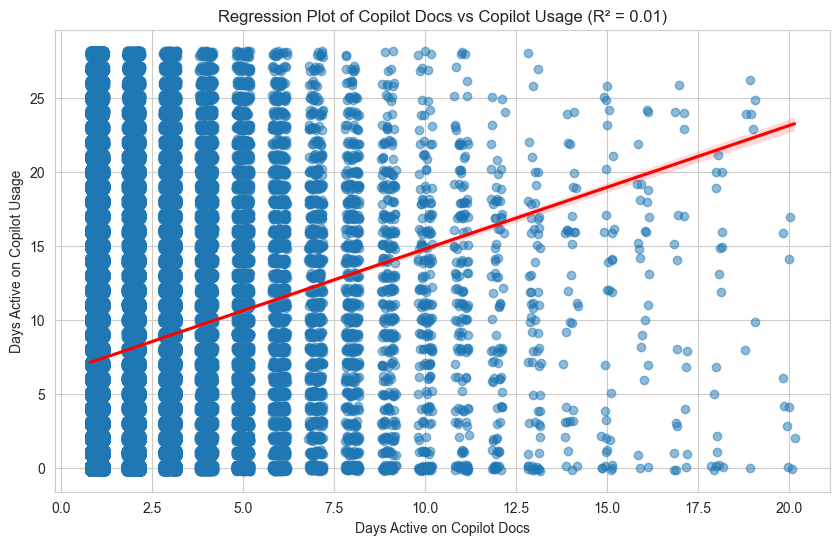

In [ ]:
filtered_data = usage_and_docs_copilot[usage_and_docs_copilot['day_count_copilot_docs'] <= 20]

plt.figure(figsize=(10, 6))

# Add jitter for better visualization
jitter_docs = filtered_data['day_count_copilot_docs'] + np.random.uniform(-0.2, 0.2, size=len(filtered_data))
jitter_usage = filtered_data['day_count_copilot_usage'] + np.random.uniform(-0.2, 0.2, size=len(filtered_data))

X = jitter_docs.values.reshape(-1, 1) 
y = jitter_usage.values  

# Fit a linear regression model
model = LinearRegression()
model.fit(X, y)

y_pred = model.predict(X)

r2 = r2_score(y, y_pred)

plt.figure(figsize=(10, 6))
sns.regplot(x=jitter_docs, y=jitter_usage, scatter_kws={'alpha': 0.5}, line_kws={'color': 'red'})
plt.title(f'Regression Plot of Copilot Docs vs Copilot Usage (R² = {r2:.2f})')
plt.xlabel('Days Active on Copilot Docs')
plt.ylabel('Days Active on Copilot Usage')
plt.grid(True)
plt.show()

Regression line is very weak which indicates there is no linear relationship between Copilot Docs views and Copilot usage.